## Introduction

In this notebook, we'll show how to serialize the three separate components of Stable Diffusion as SavedModels with XLA compilation:

* Text encoder
* Diffusion model
* Decoder

The SavedModels are needed to be able to deploy using TensorFlow Serving and the TF deployment ecosystem in general.

For each of the above components, we'll first serialize them as a SavedModel resource. We'll then show how to load the SavedModels individually and run inference with them.

We'll conclude by collating all the SavedModels together and invoking them in succession so that users can provide text prompts as inputs and get generated images as outputs. 

## Installation

In [1]:
!pip install git+https://github.com/keras-team/keras-cv -q

  Preparing metadata (setup.py) ... done


## Imports

In [2]:
import time
import base64
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.decoder import Decoder

## Model instantiation

In [4]:
MAX_PROMPT_LENGTH = 77
IMG_HEIGHT = 512
IMG_WIDTH = 512

text_encoder = TextEncoder(MAX_PROMPT_LENGTH)
diffusion_model = DiffusionModel(IMG_HEIGHT, IMG_WIDTH, MAX_PROMPT_LENGTH)
decoder = Decoder(IMG_HEIGHT, IMG_WIDTH)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Diffusion model (that refines the latent)

The diffusion model takes several steps to refine the provided latent inputs. Say you have deployed the diffusion model as is as some endpoint. In its trivial form, you'd then have to call the deployed endpoint several times for the refinement step. The SavedModel serialized below wraps this entire logic so that you don't have to call the endpoint multiple times for refinement.

***`BATCH_SIZE` here and in the subsequent sections denotes the number of images to generate from the given prompt.*** 

In [5]:
from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD
import tensorflow as tf

signature_dict = {
    "context": tf.TensorSpec(shape=[None, 77, 768], dtype=tf.float32, name="context"),
    "unconditional_context": tf.TensorSpec(
        shape=[None, 77, 768], dtype=tf.float32, name="unconditional_context"
    ),
    "num_steps": tf.TensorSpec(shape=[], dtype=tf.int32, name="num_steps"),
    "unconditional_guidance_scale": tf.TensorSpec(
        shape=[], dtype=tf.float32, name="unconditional_guidance_scale"
    )
}


def diffusion_model_exporter(model: tf.keras.Model):
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    MAX_PROMPT_LENGTH = 77
    _ALPHAS_CUMPROD_tf = tf.constant(_ALPHAS_CUMPROD)
    BATCH_SIZE = 3 # Needs to be fixed otherwise the `tf.repeat()` will be complain.
    SEED = None

    @tf.function
    def get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        img_height = tf.cast(tf.math.round(IMG_HEIGHT / 128) * 128, tf.int32)
        img_width = tf.cast(tf.math.round(IMG_WIDTH / 128) * 128, tf.int32)

        num_steps = inputs["num_steps"]
        context = inputs["context"]
        unconditional_context = inputs["unconditional_context"]
        unconditional_guidance_scale = inputs["unconditional_guidance_scale"]

        latent = tf.random.normal((BATCH_SIZE, img_height // 8, img_width // 8, 4))

        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas = tf.map_fn(lambda t: _ALPHAS_CUMPROD_tf[t], timesteps, dtype=tf.float32)
        alphas_prev = tf.concat([[1.0], alphas[:-1]], 0)

        index = num_steps - 1
        latent_prev = None
        for timestep in timesteps[::-1]:
            latent_prev = latent
            t_emb = get_timestep_embedding(timestep, BATCH_SIZE)
            unconditional_latent = model(
                [latent, t_emb, unconditional_context], training=False
            )
            latent = model([latent, t_emb, context], training=False)
            latent = unconditional_latent + unconditional_guidance_scale * (
                latent - unconditional_latent
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            pred_x0 = (latent_prev - tf.math.sqrt(1 - a_t) * latent) / tf.math.sqrt(a_t)
            latent = (
                latent * tf.math.sqrt(1.0 - a_prev) + tf.math.sqrt(a_prev) * pred_x0
            )
            index = index - 1

        return {"latent": latent}

    return serving_fn

In [6]:
tf.saved_model.save(
    diffusion_model,
    "./diffusion_model/1/",
    signatures={"serving_default": diffusion_model_exporter(diffusion_model)},
)

Instructions for updating:
Use fn_output_signature instead


In [7]:
from tensorflow.python.saved_model import tag_constants

saved_model_loaded = tf.saved_model.load(
    "./diffusion_model/1/", tags=[tag_constants.SERVING]
)
predict_fn = saved_model_loaded.signatures["serving_default"]
xla_predict_fn = tf.function(predict_fn, jit_compile=True)

Instead of explicitly doing `tf.function(your_function, jit_compile=True)` we could have also set `jit_compile=True` during decorating the `serving_fn()` function above with `tf.function`. 

We need to call the XLA-compiled functions on some inputs so that the variables are properly created. This also includes the actual graph compilation step. 

In [8]:
batch_size = tf.constant(3)
context = tf.random.normal((batch_size, 77, 768))
num_steps = tf.constant(10)
unconditional_context = tf.random.normal((batch_size, 77, 768))
unconditional_guidance_scale = tf.constant(10.5)

xla_outputs = xla_predict_fn(
    context=context,
    num_steps=num_steps,
    unconditional_context=unconditional_context,
    unconditional_guidance_scale=unconditional_guidance_scale,
)
xla_outputs.keys()

dict_keys(['latent'])

We get roughly 36% seepd boost when using the XLA-compiled function for diffusion. For more details refer to [this notebook](https://colab.research.google.com/gist/sayakpaul/845d408bcdca95e3651a6b333886e0c3/scratchpad.ipynb).

## Decoder (that generates images given the latents)

In [9]:
signature_dict = {
    "latent": tf.TensorSpec(shape=[None, 64, 64, 4], dtype=tf.float32, name="latent"),
}

def decoder_exporter(model: tf.keras.Model):
    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        latent = inputs["latent"]
        decoded = model(latent, training=False)
        decoded = ((decoded + 1) / 2) * 255
        images = tf.clip_by_value(decoded, 0, 255)
        images = tf.cast(images, tf.uint8)
        return {"generated_images": images}

    return serving_fn

In [10]:
tf.saved_model.save(
    decoder,
    "./decoder/1/",
    signatures={"serving_default": decoder_exporter(decoder)},
)

In [11]:
batch_size = 3 # The ones we set previously. 

saved_model_loaded = tf.saved_model.load("./decoder/1/", tags=[tag_constants.SERVING])
decoder_predict_fn = saved_model_loaded.signatures["serving_default"]
xla_decoder_predict_fn = tf.function(decoder_predict_fn, jit_compile=True)
xla_decoder_predict_fn(latent=tf.random.normal((batch_size, 64, 64, 4))).keys()

dict_keys(['generated_images'])

## Text encoder + tokenizer

The Tokenizer uses pure Python utilities and hence probably cannot be immediately serialized into a `tf.function`. The text encoder embeds the text prompt in the feature space. The text embeddings are a part of the inputs needed by the diffusion model.

In [12]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

In [13]:
signature_dict = {
    "tokens": tf.TensorSpec(shape=[None, 77], dtype=tf.int32, name="tokens"),
}

def text_encoder_exporter(model: tf.keras.Model):
    BATCH_SIZE = 3
    MAX_PROMPT_LENGTH = 77
    POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)
    UNCONDITIONAL_TOKENS = tf.convert_to_tensor([_UNCONDITIONAL_TOKENS], dtype=tf.int32)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        # context
        encoded_text = model([inputs["tokens"], POS_IDS], training=False)
        encoded_text = tf.squeeze(encoded_text)

        if tf.rank(encoded_text) == 2:
            encoded_text = tf.repeat(
                tf.expand_dims(encoded_text, axis=0), BATCH_SIZE, axis=0
            )

        # unconditional context
        unconditional_context = model([UNCONDITIONAL_TOKENS, POS_IDS], training=False)

        unconditional_context = tf.repeat(unconditional_context, BATCH_SIZE, axis=0)
        return {"context": encoded_text, "unconditional_context": unconditional_context}

    return serving_fn

In [14]:
tf.saved_model.save(
    text_encoder,
    "./text_encoder/1/",
    signatures={"serving_default": text_encoder_exporter(text_encoder)},
)

In [15]:
saved_model_loaded = tf.saved_model.load(
    "./text_encoder/1/", tags=[tag_constants.SERVING]
)
text_encoder_predict_fn = saved_model_loaded.signatures["serving_default"]
# Raises error
# xla_text_encoder_predict_fn = tf.function(text_encoder_predict_fn, jit_compile=True)
text_encoder_predict_fn(tokens=tf.ones((batch_size, 77), tf.int32)).keys()

dict_keys(['unconditional_context', 'context'])

Text encoder XLA compilation raises a weird error:

```
InvalidArgumentError: Graph execution error:

left_branch_shape.rank() != right_branch_shape.rank() (4 vs 3)
	 [[{{node cond}}]]
	 [[StatefulPartitionedCall]] [Op:__inference_signature_wrapper_426012]
```

Have reported the issue [here](https://github.com/tensorflow/tensorflow/issues/59818).

## An end-to-end example

In [16]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [17]:
import numpy as np

PADDING_TOKEN = 49407

gpus = tf.config.list_logical_devices("GPU")
tokenizer = SimpleTokenizer()

def generate_images_from_text(
    text: str, unconditional_guidance_scale: float = 7.5, num_steps: int = 25
) -> np.ndarray:
    num_steps = tf.constant(num_steps)
    unconditional_guidance_scale = tf.constant(unconditional_guidance_scale)

    tokens = tokenizer.encode(text)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)

    with tf.device(gpus[0].name):
        encoded_text = text_encoder_predict_fn(
            tokens=tokens
        )

        latents = xla_predict_fn(
            context=encoded_text["context"],
            num_steps=num_steps,
            unconditional_context=encoded_text["unconditional_context"],
            unconditional_guidance_scale=unconditional_guidance_scale
        )

        decoded_images = xla_decoder_predict_fn(latent=latents["latent"])
    return decoded_images["generated_images"].numpy()

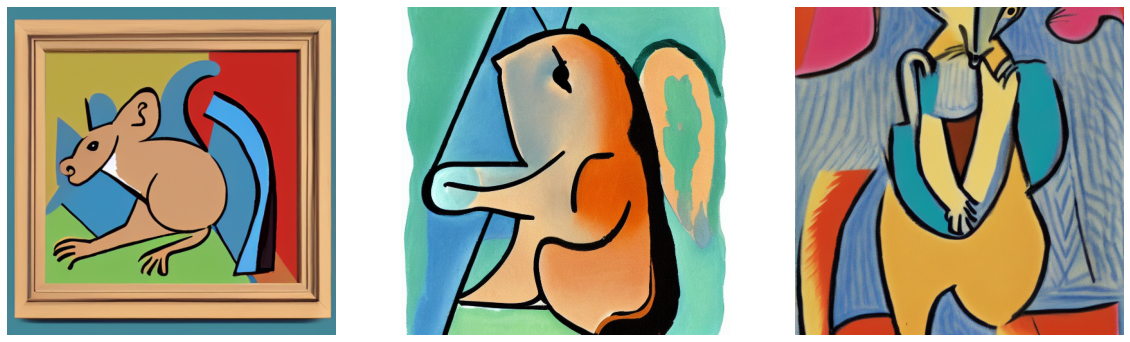

In [18]:
plot_images(generate_images_from_text("An image of a squirrel in Picasso style"))

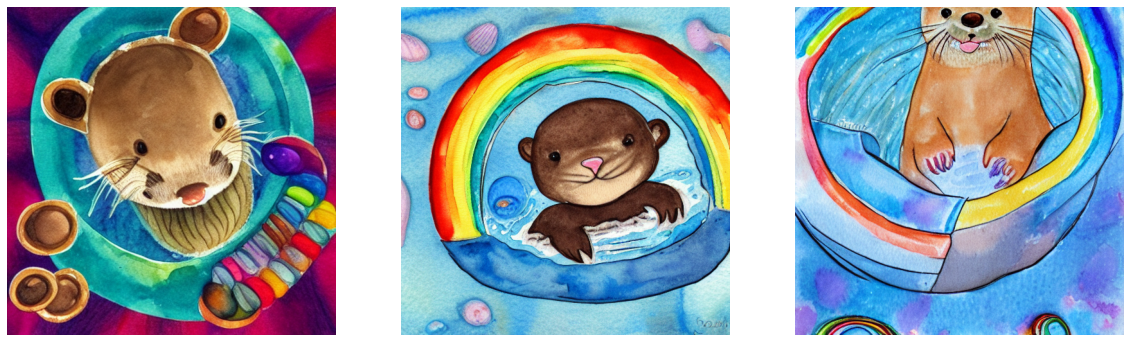

In [19]:
plot_images(
    generate_images_from_text(
        "A cute otter in a rainbow whirlpool holding shells, watercolor"
    )
)

## Benchmarking

In [20]:
import timeit 
import numpy as np

In [22]:
xla_runtimes = timeit.repeat(
    lambda: generate_images_from_text(
        "A cute otter in a rainbow whirlpool holding shells, watercolor"
    ), number=1, repeat=25
)
print(f"Average latency (seconds): {np.mean(xla_runtimes)}.")

Average latency (seconds): 4.418605104319977.
